(ch_imgclassification)=
# Image classification

Machine learning is often categorized as a subfield of artificial intelligence that “uses statistical techniques to give computers the ability to learn without being explicitly programmed” (Arthur 1959, Wikipedia). Evolved from pattern recognition, and referred originally to the construction of algorithms that can learn from and make predictions on data (Kohavi & Provost 1998). 

Categories:
    
1.) **Supervised learning**: Modelling the relationship between measured features and some associated label.
Often applied afterwards to new, unknown data.
Subcategories: classification (discrete labels) and regression (cont. labels)

2.) **Unsupervised learning**: Modelling features of a dataset without reference to any label
Main applications: clustering (i.e., identification of distinct groups), dimensionality reduction (i.e., search for more distinct representations of data)

The Python Data Science Handbook has an excellent chapter (5) on machine learning with Python {cite:p}`vanderplas16`. Please carefully read this chapter and/or follow the accompanying notebooks.
    
In this course, we will use the `scikit-learn` library. Python's `scikit-learn` contains a large collection of algorithms for classification, regression, clustering, transformations, feature extraction, model selection, and more. Check out their [webpage](https://scikit-learn.org/stable/) for more information.


## Imports

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from osgeo import gdal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # z-transformation
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # Support vector classifier
from sklearn import metrics # Accuracy assessment
import geopy_ml_fun as geopy # Visualize and save map

gdal.UseExceptions()

inpath = "../../data/landsat_stm_berlin"
outpath = "../../outputs/machine_learning"
refpath = "../../data/ml_2022"

## Example

In this example, we train and evaluate a support vector machine classification to produce a land cover map using a sample of Landsat pixels with known reference labels (land cover) and extracted statistical features as predictors. Before starting, we need to standardize the feature matrix. Then, we split the reference dataset 50:50 in model training and testing data. Based on the training data, we apply a grid search to tune the hyper-parameters. Then, we estimate the overall accuracy and the class-wise accuracies. Finally, we apply the model to the Landsat feature image to create a land cover map.

### Reference data

`berlin_landsat_sample.csv`: The reference dataset contains a sample of 332 Landsat pixel. Each sample pixel has a reference class label ("class") based on the [LUCAS](https://ec.europa.eu/eurostat/web/lucas) survey and 36 satellite data features. The reference land cover class consists of 6 land cover classes (Tab. 1). The satellite features are spectral-temporal metrics of the spectral bands blue (BLU), red (RED), near-IR (NIR), and two short-wave IR bands (SW1 and SW2). The column names show the band name abbreviation followed by the statistical metric: standard deviation (STD) and the 5th, 25th, 50th, 75th, and 95th percentile of the temporal distribution between March and October of 2018.

| Id | Class name |
| --- | :--- |
| 1 | Artificial land |
| 2 | Cropland |
| 3 | Grassland |
| 4 | Forest broadleaved |
| 5 | Forest coniferous |
| 6 | Water |

Since the reference is in CSV format, we can easily read it as a pandas Data.frame. You see, the dataset has 332 rows (observations) and 37 columns.

In [2]:
lucas = pd.read_csv(os.path.join(refpath, 'berlin_landsat_sample.csv'))
lucas.shape

(332, 37)

In [3]:
lucas.head()

class  BLU_Q05  BLU_Q25  BLU_Q50  BLU_Q75  BLU_Q95  BLU_STD  GRN_Q05  \
0      2      464      656      797      992     1084      228      811   
1      2      416      640      871      992     1105      218      646   
2      3      376      435      475      537      568       62      738   
3      2      404      827      947      996     1003      236      675   
4      2      469      615      758     1327     1358      343      982   

   GRN_Q25  GRN_Q50  ...  SW1_Q50  SW1_Q75  SW1_Q95  SW1_STD  SW2_Q05  \
0      953     1046  ...     2731     3208     3307      768      653   
1      950     1140  ...     2693     3008     3394      617      816   
2      740      772  ...     2384     2467     2740      218     1113   
3     1159     1312  ...     3365     3425     3823      796      732   
4     1051     1120  ...     2126     3423     3682      921      598   

   SW2_Q25  SW2_Q50  SW2_Q75  SW2_Q95  SW2_STD  
0     1105     2024     2373     2583      714  
1     1350     1925     2629     2838      748  
2     1298     1395     1597     1638      192  
3     1414     2545     2851     3114      861  
4      908     1293     2806     2993      954  

[5 rows x 37 columns]

### Landsat data

**`X0068_Y0043_landsat_stm_2018.tif`**: The Landsat image contains 36 statistical metrics derived from Landsat observations acquired over the year 2018 (March to October). The statistical metrics are the same statistical metrics as shown in the reference dataset.


In [4]:
lnd_file = os.path.join(inpath, "X0069_Y0043_landsat_stm_2018.tif")
ds_src = gdal.Open(lnd_file)
lnd_img = ds_src.ReadAsArray()
lnd_img.shape

(36, 3000, 3000)

To access the name of a band, we need to create a band object and call `GetDescription()` on it. If we want to retrieve all band names, we need to loop through all raster band objects. Below, we write a loop inside a list comprehension to achieve that. Note, that we must extract bands with `x+1` since the gdal band index starts with 1 and the python index starts with 0.

In [5]:
bnames = [ds_src.GetRasterBand(x+1).GetDescription() for x in range(ds_src.RasterCount)]
bnames[:7]

['BLU_Q05', 'BLU_Q25', 'BLU_Q50', 'BLU_Q75', 'BLU_Q95', 'BLU_STD', 'GRN_Q05']

It is a good idea to visualize the Landsat image to see if we imported everything correctly. Let's visualize the median image with the band combination `NIR_Q50`, `RED_Q50`, and `GRN_Q50`. To do that, we need to find the positions of those bands in the raster image. Again, we can write a list comprehension to loop over the band names, but that gives us only a single position. To understand what `enumerate` does click [here](sub_enumerate) does.

In [6]:
[i for i, x in enumerate(bnames) if x == "NIR_Q50"]

[14]

To get the positions of all three bands, we can write a nested list comprehension that combines looping over the band names of the raster and the band names of our desired band combination.

In [7]:
band_combination = ["NIR_Q50", "RED_Q50", "GRN_Q50"]
[[i for i, x in enumerate(bnames) if x == k] for k in band_combination]

[[14], [20], [8]]

This is to show you the power of list comprehensions in Python. Don't be afraid to use them unless you have large datasets. We can also take advantage of the search functionality of pandas Series and DataFrames.

In [8]:
bc = pd.Series(bnames)
bc[bc.isin(["GRN_Q50", "RED_Q50", "NIR_Q50"])]


8     GRN_Q50
14    NIR_Q50
20    RED_Q50
dtype: object

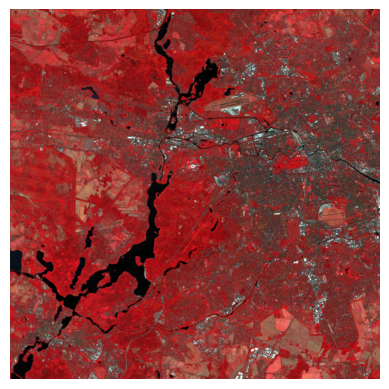

In [9]:
geopy.plot_boa(lnd_img, bands=[14, 20, 8])

## Data format

In scikit-learn examples, it is customary to explicitly create the variables `y` (for the target vector or response) and `X` (for the feature matrix or predictors). You do not have to follow that convention, but it makes your code easier to read. Scikit-learn accepts *numpy* arrays and *pandas* Data.frames and Series. Here, we extract the target vector and feature matrix from the pandas Data.frame.

In [10]:
y = lucas['class']
y.shape

(332,)

In [11]:

X = lucas.drop(['class'], axis=1) # or X = lucas.iloc[:, 1:]
X.shape

(332, 36)

## Feature scaling

Feature scaling standardizes the predictors in your feature matrix. Feature scaling is important when predictors are highly varying in magnitude, e.g., when different units are involved. If such data is not scaled, machine learning algorithms that work with variances and/or distances will underperform because they will only utilize the features with the highest variance. To mitigate the problem, we rescale all features to the properties of a standard normal distribution with mean zero (μ = 0) and standard deviation one (σ = 1) using scikit-learn. The `StandardScale()` works in two steps: 1) the `fit()` estimates the distribution parameters mean and standard deviation, and 2) `transform()` applies the normalization. If you are not interested in keeping the distribution parameters, you can do the transformation in one step using `fit_transform()`.

In [12]:
fittedScaler = StandardScaler().fit(X.astype('float32'))
X_scaled = fittedScaler.transform(X.astype('float32'))
X_scaled.shape

(332, 36)

## Splitting data

Now, lets split the data set int 50% training and %50 test set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)

## Instantiate classifier

First, we create an instance of the classifier. You can check the default hyperparameters with `model.get_params()`.

In [14]:
svc_model = SVC()
svc_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Tuning

Tuning is the process of maximizing an algorithm’s performance without overfitting or underfitting. Tuning is accomplished by selecting optimal hyperparameters from a model. A hyperparameter is a configuration external to the model and whose value cannot be estimated from data. Scikit-Learn offers two functions for optimizing hyperparameter tuning: `GridSearchCV` and `RandomizedSearchCV`. GridSearchCV performs an exhaustive search over specified parameter values for an estimator (or machine learning algorithm) and returns the best performing hyperparametric combination. RandomizedSearchCV uses randomized selections of hyperparameters and therefore tends to be less computationally expensive. SVM has two hyperparameters: `C` and `gamma`. Below, we conduct a grid search using three-fold cross-validation to evaluate the performance of each hyperparameter combination.

In [15]:
param_grid = {'C': [1, 5, 10, 40, 50, 60],
              'gamma': [0.0005, 0.001, 0.005, 0.006, 0.007]}
grid = GridSearchCV(svc_model, param_grid, cv=3)

grid.fit(X_train, y_train)
grid.best_params_

{'C': 5, 'gamma': 0.006}

From the fitted grid search object, we extract the best parameters (see above) and the best model (see below).

In [16]:
lc_model = grid.best_estimator_
lc_model.get_params()

{'C': 5,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.006,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Model Accuracy

Model accuracy can be describe class-wise and overall. Precision (User's accuracy) and Recall (Producer's accuracy) describe the accuracy at the class level. Precision (User's accuracy) describes the proportion of positive identifications that was actually correct:

$Precision = \frac{TP}{TP+FP}$

Recall describes the proportion of actual positives that was identified correctly:

$Recall = \frac{TP}{TP+FN}$
 
where, TP: true positives, FP: false positives, and FN: false negatives. To fully evaluate the effectiveness of a model, you must examine *both* precision and recall.

Apply model to the test data:

In [17]:
y_pred = lc_model.predict(X_test)
y_pred

array([5, 6, 6, 5, 4, 3, 5, 6, 6, 6, 6, 5, 3, 2, 5, 6, 5, 5, 6, 2, 3, 3,
       5, 5, 3, 4, 3, 5, 3, 2, 3, 2, 3, 3, 5, 5, 1, 5, 2, 6, 6, 4, 3, 5,
       6, 3, 1, 2, 5, 2, 5, 5, 3, 3, 2, 2, 4, 4, 5, 3, 1, 4, 5, 3, 1, 2,
       3, 3, 6, 6, 1, 2, 6, 2, 5, 6, 6, 3, 5, 6, 1, 5, 3, 3, 4, 2, 3, 5,
       5, 3, 2, 5, 3, 2, 5, 5, 5, 5, 5, 6, 3, 6, 3, 1, 6, 6, 6, 5, 1, 5,
       5, 5, 5, 6, 2, 3, 3, 6, 5, 3, 5, 3, 5, 1, 2, 5, 6, 6, 3, 5, 5, 1,
       6, 6, 5, 4, 1, 2, 3, 3, 3, 2, 6, 3, 4, 1, 4, 5, 6, 3, 6, 5, 6, 5,
       5, 3, 1, 5, 3, 3, 5, 1, 4, 4, 6, 6])

What is the probabiliy that a pixel is correctly classified?

In [18]:
print('Accuracy: %.4f' % metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8554


### Confusion matrix

In [19]:

metrics.confusion_matrix(y_test, y_pred)

array([[11,  0,  4,  1,  3,  0],
       [ 0, 18,  4,  0,  0,  0],
       [ 0,  1, 28,  0,  1,  0],
       [ 3,  0,  3, 11,  4,  0],
       [ 0,  0,  0,  0, 40,  0],
       [ 0,  0,  0,  0,  0, 34]])

### Accuracy statistics

In [20]:
aa_scores = metrics.precision_recall_fscore_support(y_test, y_pred)
aa_scores

(array([0.78571429, 0.94736842, 0.71794872, 0.91666667, 0.83333333,
        1.        ]),
 array([0.57894737, 0.81818182, 0.93333333, 0.52380952, 1.        ,
        1.        ]),
 array([0.66666667, 0.87804878, 0.8115942 , 0.66666667, 0.90909091,
        1.        ]),
 array([19, 22, 30, 21, 40, 34]))

### Text report

In [21]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.58      0.67        19
           2       0.95      0.82      0.88        22
           3       0.72      0.93      0.81        30
           4       0.92      0.52      0.67        21
           5       0.83      1.00      0.91        40
           6       1.00      1.00      1.00        34

    accuracy                           0.86       166
   macro avg       0.87      0.81      0.82       166
weighted avg       0.87      0.86      0.85       166



## Map predictions

Before we apply the model to the image, we need to transform the 3D-image with the shape `(n_bands, n_row, n_col)` into a 2D array of shape `(n_row * n_col, n_bands)`. To achieve that, we first need to move the `n_bands` dimension to the last axis with `transpose`. Then we can collapse the first two dimensions with `reshape`. Finally, we need to transform the predictions back to 3-D.

In [22]:
# Get size of dimensions
n_bands, n_rows, n_cols = lnd_img.shape

# Transpose the array from (n_bands, n_rows, n_cols) to (n_rows, n_cols, n_bands)
flat_img = np.transpose(lnd_img, (1, 2, 0))

# Collapse the row and column dimension to get a 2-d array
flat_img = flat_img.reshape((n_rows * n_cols, n_bands))
print('Reshaped from {o} to {n}'.format(o=lnd_img.shape, n=flat_img.shape))


Reshaped from (36, 3000, 3000) to (9000000, 36)


Rescale image to mean 0 and unit variance.

In [23]:
fittedScaler = StandardScaler().fit(flat_img)
scaled_img = fittedScaler.transform(flat_img)

Make a prediction for each pixel using the flat image array:

In [24]:
lc_flat = lc_model.predict(scaled_img)

Reshape our classified flat array back into the image shape:

In [25]:
lc_map = lc_flat.reshape(lnd_img.shape[1:])
lc_map.shape

(3000, 3000)

## Map visualization

The course module geopy has a small `plot_map()` function that also takes a list of labels and a dictionary of color codes as input. The color codes are of the format [red, green, blue, alpha], and the values range from 0 to 1.

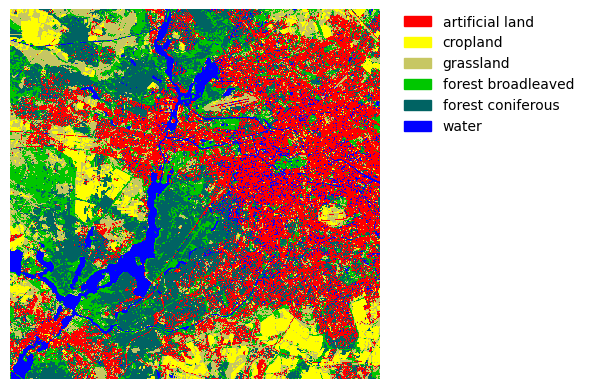

In [26]:
lcColors = {1: [1.0, 0.0, 0.0, 1.0],  # Artificial
            2: [1.0, 1.0, 0.0, 1.0],  # Cropland
            3: [0.78, 0.78, 0.39, 1.0],  # Grassland
            4: [0.0, 0.78, 0.0, 1.0],  # Forest, broadleaf
            5: [0.0, 0.39, 0.39, 1.0],  # Forest, conifer
            6: [0.0, 0.0, 1.0, 1.0]}  # Water

labels = ['artificial land', 'cropland', 'grassland', 'forest broadleaved', 'forest coniferous', 'water']
geopy.plot_map(lc_map, lcColors, labels)

## Map export

We could just save the map as a standard 8-bit (`np.ubyte()`) image. The function below also embeds a predefined color ramp into the tif file. The color values range from 0 to 255.

In [27]:
colors = dict((
    (1, (255, 0, 0)),  # Artificial
    (2, (255, 255, 0)),  # Cropland
    (3, (200, 200, 100)),  # Grassland
    (4, (0, 200, 0)),  # Forest broadleaf
    (5, (0, 100, 100)),  # Forest conifer
    (6, (0, 0, 255))  # Water
))

out_file = os.path.join(outpath, "landsat_landcover_2015.tif")
geopy.writeArray(lc_map.astype(np.ubyte()), out_file, lnd_file, colors=colors)
